# Aprendizaje Formal

## Práctica 4: Regresión Logística y Regularización

### Índice de la práctica

- [Lectura de datos](#Lectura-de-datos)
- [Regresión logística](#Regresión-logística)
- [Regresión logística con regularización](#Regresión-logística-con-regularización)

Importamos todas las librerías que vamos a utilizar durante la segunda práctica.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from test_helper import Test

from scipy.optimize import minimize

%matplotlib inline  

### Lectura de datos

Definimos una función que lee un archivo que contiene los datos de entrenamiento. La función recibe como parámetro de entrada el nombre del fichero que contiene los datos de entrenamiento así como el símbolo utilizado para separar los valores de las variables del problema (delimitador). La función muestra las dimensiones del dataset así como los 5 primeros ejemplos del mismo.

Debéis llamar a la función loadtxt de numpy con los parámetros apropiados.

In [2]:
def lecturaDatos(nombreFichero, simboloDelimitador):
    datos = np.loadtxt(nombreFichero, delimiter=simboloDelimitador)
    
    print('Dimensiones de los datos: ',datos.shape)
    print(datos[0:5,:])
    return (datos)

Definimos una función que muestre los datos de entrenamiento gráficamente. 

Esta función va a ser genérica para problemas de clasificación de dos clases por lo que
* La clase negativa va a ser la que tenga asociada la etiqueta 0
* La clase positiva va a ser la que tenga asociada la etiqueta 1

Además asumimos que la variable de salida (clase) será el último valor en cada fila de `datos`.

La función recibe como parámetros de entrada los datos, las etiquetas de los ejes x e y (dos variables de entrada) así como la etiqueta para los datos de la clase positiva y de la clase negativa (se muestran en la leyenda de la figura).

In [3]:
def muestraGrafica(datos, etiqueta_ejeX, etiqueta_ejeY, etiqueta_Positiva, etiqueta_Negativa, axes=None):
    # La variable claseNegativa debe ser un array de booleanos compuesto por tantos elementos como ejemplos
        # Los ejemplos de la clase 0 deben tener True en su correspondiente posicion del array de booleanos y False en el resto
    claseNegativa = (datos[:, -1]==0)
    
    # La variable clasePositiva debe ser un array de booleanos compuesto por tantos elementos como ejemplos
        # Los ejemplos de la clase 1 deben tener True en su correspondiente posicion del array de booleanos y False en el resto
    clasePositiva = (datos[:, -1]==1)
    
    # Si no se pasa un manejador de una figura se crea una
    if axes == None:
        fig = plt.figure(figsize=(6, 5))
        axes = fig.add_axes([0, 0, 1, 1])
        
    # Se muestra la nube de puntos: + negros para la clase 1 y circulos amarillos para la clase 0 
    # Utiliza los vectores claseNegativa y clasePositiva como máscara para pintar solo los datos correspondientes a la clase en cuestión

    # Debes utilizar la variable axes y utilizar su método scatter
    axes.scatter(datos[:, 0][clasePositiva], datos[:, 1][clasePositiva], label=etiqueta_Positiva, c='k', marker='+')
    axes.scatter(datos[:, 0][claseNegativa], datos[:, 1][claseNegativa], label=etiqueta_Negativa, c='y', marker='o')
    
    # Establecemos las etiquetas de los ejes
    axes.set_xlabel(etiqueta_ejeX)
    axes.set_ylabel(etiqueta_ejeY)
    
    # Añadimos la leyenda
    axes.legend(frameon= True, fancybox = True);

### Regresión logística

Lee datos utilizando la función definida anteriormente. El nombre del fichero a leer es ex2data1.txt y el delimitador de los valores de las variables es la coma (,).

Los datos contenidos en este fichero corresponden a un problema en el que se debe **predecir si un estudiante es admitido en una universidad o no**. El acceso a la universidad viene determinado por la nota obtenida por los estudiantes en dos exámenes realizados previamente. El archivo contiene el histórico de las notas obtenidas en ambos exámenes (variables de entrada) para 100 alumnos así como si han ingresado en la universidad o no (variable de salida).

In [4]:
# Guarda los datos en la variable datos
datos = lecturaDatos('ex2data1.txt', ',')

Dimensiones de los datos:  (100, 3)
[[34.62365962 78.02469282  0.        ]
 [30.28671077 43.89499752  0.        ]
 [35.84740877 72.90219803  0.        ]
 [60.18259939 86.3085521   1.        ]
 [79.03273605 75.34437644  1.        ]]


A continuación se crean los datos de entrada ($X$) y de salida ($y$) para poder realizar el aprendizaje de los parámetros de la regresión logística ($\theta$). Recordar que la primera columna de los datos de entrada debe estar compuesta por unos para multiplicar al término independiente de la regresión logística. Por tanto, la variable $X$ estará compuesta por tantas columnas como variables de entrada más una (la de unos). En este caso serán 3 columnas. La variable $y$ debe contener la información de si los alumnos han sido admitidos o no.

In [5]:
# Debéis crear una columna de unos y concaternala con las dos primeras columnas de datos
# Utiliza la función hstack para concatenar una matriz de m x 1 de unos y los datos en data menos su última columna
# Guarda el resultado en X
unos = np.ones((len(datos))).reshape(-1, 1)
X = np.hstack((unos, datos[:, :-1]))

# y debe ser un vector columna, es decir una matriz de m x 1. 
# Para ello, debes tomar la segunda última de data y luego haz un reshape(-1, 1). El -1 le indica a numpy que debe estimar el tamaño automáticamente
y = datos[:, -1].reshape(-1, 1)

In [6]:
Test.assertEquals(list(X[0,:]), [1.0, 34.623659624516968, 78.0246928153624], 'X no está bien formada')
Test.assertEquals(list(y[:5, 0]), [0.0, 0.0, 0.0, 1.0, 1.0], 'y no está bien formada')

1 test passed.
1 test passed.


Realizar la llamada a la función que muestra los ejemplos utilizando los datos recién leídos y las etiquetas apropiadas. Los alumnos admitidos se codifican con 1 y los no admitidos con 0. El resultado debe ser similar a la siguiente figura.
![Figura](img1.png)

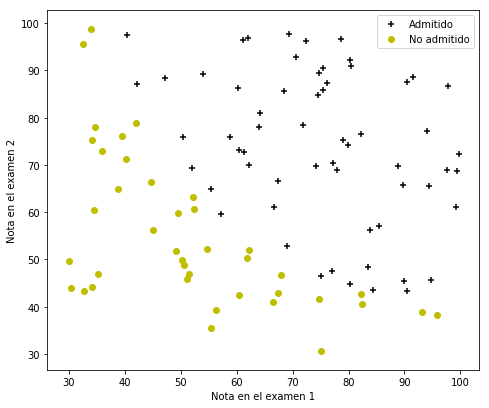

In [7]:
muestraGrafica(datos, 'Nota en el examen 1', 'Nota en el examen 2', 'Admitido', 'No admitido')

#### Modelo de regresión logística
Vamos a recordar el modelo de la regresión logística. Es el mismo que para la regresión lineal pero aplicando una función sigmoide sobre el resultado para conseguir una función convexa y, de esta forma, poder aplicar el descenso por gradiente para minimizar la función de coste.

#### Hipótesis de la regresión logística
#### $$ h_{\theta}(x) = g(\theta^{T}x)$$
#### La función $g$ es la función sigmoide definida como
#### $$ g(z)=\frac{1}{1+e^{−z}} $$

Definir la función que aplica la función sigmoide, $g(z)$, sobre un dato $z$. Este dato puede ser un array de valores.

La función exp de numpy (pasando un valor como parámetro de entrada) sirve para calular $e^{valor}$

In [8]:
def sigmoide(z):
    return 1 / (1 + np.exp(-z))

Comprobar si la función sigmoide funciona correctamente, recordar que:
* Para el valor 0.0 el resultado debe ser 0.5
* Para valores grandes el resultado debe ser muy próximo a 1.0
* Para valores pequeños el resultado debe ser muy próximo a 0.0

Ejericicio:
* Comprobar el resultado para el valor de entrada 0.0
* Comprobar el resultado para un array de numpy compuesto por los valores -5.0 y 5.0

In [9]:
# Resultado para 0.0 (almacenar en resultado1)
resultado1 = sigmoide(0.0)
print(resultado1)

# Resultado para un array con -5.0 y 5.0 (almacenar en resultado2)
resultado2 = sigmoide(np.array([-5.0, 5.0]))
print(resultado2)

0.5
[0.00669285 0.99330715]


In [10]:
Test.assertEquals(resultado1, 0.5, 'Valor incorrecto de la función sigmoide')
Test.assertEquals(list(np.round(resultado2, 5)), [0.00669,  0.99331], 'Valores incorrectos de la función sigmoide')

1 test passed.
1 test passed.


##### SciPy
La librería Scipy contiene una función que realiza exáctamente este mismo cálculo. Se puede consultar su información la siguiente URL:<BR>
http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html#scipy.special.expit

Se podría utilizar en lugar de la función sigmoide que acabamos de definir.

#### Función de coste
A continuación vamos a implementar la función de coste. Vamos a recordar su expresión normal y vectorizada.

#### $$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\big[y^{(i)}\, log\,( h_\theta\,(x^{(i)}))+(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big]$$
#### Función de coste vectorizada
Obtenemos el vector de salidas (probabilidad de que cada ejemplo pertenezca a la clase 1)

$$ h_\theta(X) = g(X\cdot \theta) $$

Utilizamos el vector columna anterior para calcular el coste total directamente

#### $$ J(\theta) = -\frac{1}{m}\big((\,log\,(h_\theta(X))^Ty+(\,log\,(1-h_\theta(X))^T(1-y)\big)$$

Definir la función de coste vectorizada mostrada anteriormente $J(\theta)$. Esta función recibe como parámetros de entrada los valores de los parámetros $\theta$ (en forma de vector columna) sobre los que calcular el coste con respecto a los datos de entrada ($X$) y sus correspondientes salidas ($y$).

In [11]:
def funcionCoste(theta, X, y):
    m = y.size
    h = sigmoide(X.dot(theta))    
    
    with np.errstate(divide='raise'):
        try:
            J = (-1 / m) * ((np.log(h.T).dot(y)) + (np.log(1 - h.T)).dot(1 - y))
        except FloatingPointError: J = np.inf
    return J

Recordamos como son las derivadas parciales para poder definir la función que aplica el descenso por gradiente y de esta forma aprender los valores de los parámetros de la regresión logística ($\theta$)

#### Derivada parcial

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})\cdot x^{(i)}_{j} $$ 
#### Derivada parcial vectorizada
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(h_\theta(X)-y)$$
donde $$ h_\theta(X) = g(X\cdot \theta) $$


Definir la función que realiza la derivada parcial vectorizada mostrada previamente. Esta función recibe como parámetros de entrada los valores iniciales de los parámetros de la regresión logística ($\theta$) así como los valores de las variables de entrada del problema ($X$) y sus correspondientes salidas ($y$).

En la variable $h$ tenemos el resultado de $g(X\cdot \theta)$

Ejercicio: 
* Implementa la ecuación de la derivada parcial $\frac{1}{m} X^T(h_\theta(X)-y)$

** NOTA: Esta función la vamos a usar en una función minimize que realizará el descenso por gradiente. Dicha función en vez de pasar theta como una matriz de (3, 1), nos pasará una de (3, ) por lo que debes hacer un reshape antes de realizar el producto entre X y theta**

In [12]:
def derivadaParcial(theta, X, y):
    m = y.size
    theta = theta.reshape(-1, 1)
    
    h = sigmoide(X.dot(theta))
    
    derParcial = (1 / m) * X.T.dot(h - y)

    return(derParcial.flatten()) # La salida debe ser un vector

Ejercicio:
* Crear los valores iniciales de los parámetros de la regresión logística como un vector columna de ceros. 
* Comprobar el coste del modelo con los datos leídos utilizando estos valores iniciales de los parámetros $\theta$.
* Obtener los valores de la derivada parcial de los parámetros de la regresión logística llamando a la función que la realiza utilizando los datos de entrenamiento leídos anteriormente.

In [13]:
# Creación de la columna de ceros en thetaInicial
thetaInicial = np.zeros((datos.shape[1], 1))

# Llamada a la funcion de calculo del coste, almacenar resultado en costeInicial
costeInicial = funcionCoste(thetaInicial, X, y)
# Llamada a la funcion que realiza la derivada parcial, almacenar resultado en derParcial
derParcial = derivadaParcial(thetaInicial, X, y)

print('Coste del modelo inicial: \n', costeInicial)
print('Derivada parcial: \n', derParcial)

Coste del modelo inicial: 
 [[0.69314718]]
Derivada parcial: 
 [ -0.1        -12.00921659 -11.26284221]


In [14]:
Test.assertEquals(np.round(costeInicial, 5), 0.69315, 'Valor de coste incorrecto')
Test.assertEquals(list(np.round(derParcial, 5)), [-0.1,  -12.00922, -11.26284], 'Valores de la derivada parcial incorrectos')

1 test passed.
1 test passed.


#### Optimización de la función de coste

Para realizar el aprendizaje de los parámetros de la regresión logística vamos a utilizar la función `minimize` importada al comienzo de la práctica. Esta función realiza el proceso de descenso por gradiente y recibe como parámetros de entrada:
* La función que calcula el coste del modelo
* Los valores iniciales de los parámetros del modelo (variable thetaInicial) 
* Los valores de los ejemplos de entrenamiento (tanto de las variables de entrada ($X$) como de salida ($y$)) en forma de tupla (parámetro args)
* La función que realiza las derivadas parciales (parámetro jac)
* El número máximo de iteraciones del descenso por gradiente (establecido a 400)

Puedes ver los detalles sobre esta función aquí: https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html

Los parámetros del modelo aprendidos ($\theta$) se devuelven en el campo x de la variable utilizada para recoger la salida de la función minimize. En este caso se pueden consultar imprimiedo res.x. Este vector está en formato de fila, pásalo a formato columna para poder seguir usándo la variable thetas como hasta ahora.

In [15]:
# Los primeros dos parámetros son la función de coste y los valores de theta iniciales (en formato fila). 
# El resto de parámetros deben ser args=(X,y), jac=derivadaParcial y options={'maxiter':400}
# Almacenar resultado en res
res = minimize(funcionCoste, thetaInicial, args=(X, y), jac=derivadaParcial, options={'maxiter':400})

# Obtén los valores de thetas a partir de res.x y pásalos a formato columna. Guarda el resultado en thetas
thetas = res.x.reshape(-1, 1)
print(thetas)

[[-25.16131634]
 [  0.2062316 ]
 [  0.20147143]]


In [16]:
Test.assertEquals(list(np.round(thetas, 5)), [-25.16132, 0.20623, 0.20147], 'Valores de theta incorrectos')

1 test passed.


#### Predicción de nuevos datos

Para predecir la clase de nuevos estudiantes se debe definir una función que recibe los valores de los parámetros del modelo ($\theta$), una lista de lista con los valores de las variables de entrada de todos los alumnos ($X$) y un umbral para decidir si se predice la clase admitido o no admitido. La función sigmoide definida anteriormente devuelve un valor en el intervalo $[0, 1]$ que debemos transformar a $0$ o $1$. Para realizar este proceso utilizamos el umbral de tal forma que si el valor devuelto por la función sigmoide es menor que el umbral se obtiene False (0) y en otro caso True (1). Por tanto, este umbral por defecto debe ser $0.5$ para que ambas clases tengan la misma probabilidad de ser predichas.

Ejercicio:
* Calcular la probabilidad de admisión de todos los alumnos (función sigmoide pasando el resultado de la ecuación del modelo $X\cdot \theta$). 
    * Se asigna a la variable `p`.
* Comparar cada valor devuelto por la función sigomide (almacenado en `p`) con el umbral para obtener si son admitidos (mayor o igual que el umbral: True) o no (menor que el umbral: False). 
    * La variable `p` se actualiza con este resultado.

In [17]:
def prediccion(theta, X, umbral=0.5):
    p = sigmoide(X.dot(theta))
    p = p >= umbral
    # La función astype la utilizamos para convertir booleanos (False (0), True (1)) en números enteros {0, 1}.
    return (p.astype('int'))

Calcular la probabilidad de admisión de un estudiante que ha obtenido un 45 en el primer examen y un 85 en el segundo. Para ello se debe llamar a la función sigmoide que nos devuelve la probabilidad de que un estudiante sea admitido (número entre 0 y 1 como se ha mencionado en el apartado previo).

Ejercicio:
* Definir el array de numpy con los datos del alumno para que pueda ser predicho por el modelo (acordaros de incluir el 1).
* Utilizar la función sigmoide para clasificar el alumno junto con los parámetros del modelo($\theta$).

In [18]:
# Predecir utilizando los theta obtenidos tras aplicar la función minimize (thetas) - guardar resultado en probabilidad
alumno = np.array([1, 45, 85]).reshape(1, -1)
probabilidad = sigmoide(alumno.dot(thetas))
print(probabilidad)

[[0.77629032]]


In [19]:
Test.assertEquals(np.round(probabilidad, 5), 0.77629, 'Valor de probabilidad incorrecto')

1 test passed.


Ejercicio:
* Realizar la predicción de todos los alumnos almacenados en el fichero que contiene el histórico (el leído al comienzo de la práctica). 
    * Llamar a la función predicción definida anteriormente pasando los valores de los parámetros del modelo ($\theta$) y los datos a predecir.
* Obtener el porcentaje de acierto aplicando los siguientes pasos:
    * Obtener un array de booleanos comprobando si los alumnos se predicen correctamente o no (es decir, comparar `p` con `y`.
    * Obtener el número de alumnos correctamente predichos, sumar el array anterior (con la función sum se suman los True ya que son unos)
    * Obtener el porcentaje de alumnos correctamente predichos divididiendo la suma anterior entre el número total de alumnos (p.size) y multiplicado por 100. 
        * Este resultado se almacena en la variable accuracy.

In [20]:
p = prediccion(thetas, X)
boolean_array = (p == y)
correct = np.sum(boolean_array)
accuracy = correct / p.size * 100

print('Precisión en entrenamiento {}%'.format(accuracy))

Precisión en entrenamiento 89.0%


In [21]:
Test.assertEquals(round(accuracy, 1), 89.0, 'Valor de accuracy incorrecto')

1 test passed.


#### Frontera de decisión

Ahora vamos a mostrar la frontera de decisión que genera el modelo de regresión logística que acabamos de aprender. Recordar que la frontera de decisión se genera en el punto en el que las probabilidades del ejemplo a todas las clases son iguales y, por tanto, no se sabe determinar la clase. A partir de ese punto la clase cambia entre las que estén afectadas por la frontera (generalmente dos).

**NOTA:**
* Fijaros en como se obtiene la frontera de decisión (línea azul): se aplica la sigmoide (probabilidad de cada alumno) y se muestran solamente los alumnos cuya probabilidad sea 0.5.

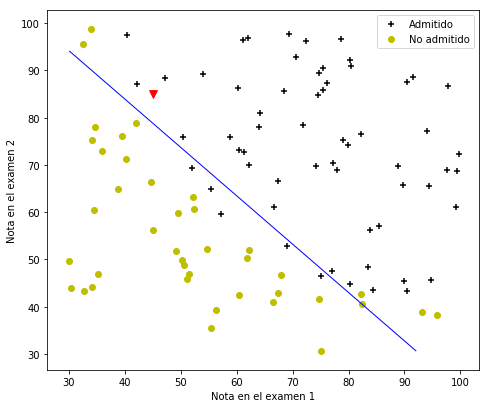

In [22]:
# En primer lugar, muestra la gráfica de los datos
muestraGrafica(datos, 'Nota en el examen 1', 'Nota en el examen 2', 'Admitido', 'No admitido')
# Mostramos el punto que hemos clasificado anteriormente como un triángulo rojo
plt.scatter(45, 85, s=60, c='r', marker='v', label='(45, 85)')
# Calculamos el mínimo y máximo de cada variable de entrada
x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),
# Obtenemos todas las combinaciones de valores de las dos variables (comprendidos entre el mínimo y el máximo y espaciados linealmente)
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

# Aplicamos la función sigmoide para obtener la probabilidad de admisión de todas las combinaciones anteriores
h = sigmoide(np.hstack((np.ones((xx1.size, 1)), xx1.reshape(-1, 1), xx2.reshape(-1, 1))).dot(thetas))
h = h.reshape(xx1.shape)

# Mostramos con una línea azul todos las combinaciones cuya probabilidad de admisión sea 0.5 (equiprobable: no sabemos elegir)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')

### Regresión logísticas con Scikit-learn
Al igual que con la regresión lineal, el paquete scikit-learn también tiene el método de la regresión logística implementado. Lo puedes consultar en http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

Vamos a comprobar si el resultado obtenido es similar. Para ello, vamos a volver a pintar la gráfica anterior pero entrenaremos el modelo con la clase LogisticRegression de scikit-learn. La regresión logística de de sklearn está implementada con la regularización, pero eso lo veremos en la segunda parte de la práctica. 
 
`LogisticRegression` requiere de los siguientes parámetros:
* penalty: Elegir 'l2' (es el tipo de regularización a realizar)
* C: Es el valor que corresponde a lambda, pero en este caso $ C = 1/\lambda$. Como no queremos regularizar, este valor debe ser un valor muy alto, por ejemplo $10.0e50$
* max_iter: Número máximo de iteraciones para el descenso por gradiente (400)
* solver: Este es el método a utilizar para buscar el mínimo. Puede ser cualquiera de entre {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’}. Utilizar newton-cg para esta prueba

Una vez creado el objeto de `LogisticRegression` debes utilizar el método `fit`. Como entrada toma la matriz $X$ (**CUIDADO** sin coger la columna de unos) y el vector $y$ (ponerlo en modo vector usando ravel).

Con dicha operación logramos ajustar los parámetros y ya podemos usar el objeto para predecir nuevos valores (los coeficientes obtenidos están en coef$\_$ y intercept$\_$, pero es más sencillo utilizar la función `predict_proba` para obtener las probabilidades de salida para cada ejemplo. Esta función recibe la matriz $X$ de entrada (sin la columna de unos) y devuelve una matriz de $m \times 2$. De esta matriz solo nos interesa la segunda columna que es la que tiene la probabilidad de que un ejemplo pertenezca a la clase 1. 

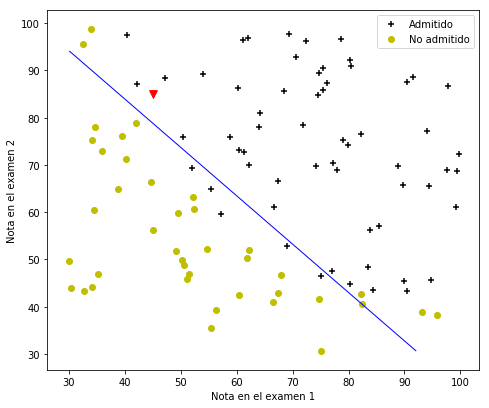

In [23]:
# Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a la regresión lineal
from sklearn.linear_model import LogisticRegression

# Calculamos el mínimo y máximo de cada variable de entrada
x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),

# Obtenemos todas las combinaciones de valores de las dos variables (comprendidos entre el mínimo y el máximo y espaciados linealmente)
# Almacenar resultado en xx1, xx2
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

#solver : {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’}
# Se incializa el modelo llamando al constructor de la regresión lineal: todos los parámetros se asignan a los valores comentados anteriores
# Almacenar objeto en LogReg
LogReg = LogisticRegression(penalty='l2', C=10.0e50, max_iter=400, solver='newton-cg')

# Se entrena el modelo (aprendizaje) utilizando la variable de entrada sin los unos X[:,1] y la variable de salida (y)
# La función ravel devuelve una lista (si la entrada es una lista de listas coge todos los elementos y los almacena en la lista devuelta)
LogReg.fit(X[:, 1:], y.ravel())

# Se evalúan los valores creados anteriormente para comparar ambos modelos aprendidos. Utiliza LogReg.predict_proba y almacena
# la probabilidad de que sea de la clase 1 en h
h = LogReg.predict_proba(np.hstack((xx1.reshape(-1, 1), xx2.reshape(-1, 1))))[:, 1]
h = h.reshape(xx1.shape)


# En primer lugar, muestra la gráfica de los datos
muestraGrafica(datos, 'Nota en el examen 1', 'Nota en el examen 2', 'Admitido', 'No admitido')
# Mostramos el punto que hemos clasificado anteriormente como un triángulo rojo
plt.scatter(45, 85, s=60, c='r', marker='v', label='(45, 85)')
# Mostramos con una línea azul todos las combinaciones cuya probabilidad de admisión sea 0.5 (equiprobable: no sabemos elegir)
plt.contour(xx1, xx2, h, [0.5], linewidths=1, colors='b');

### Regresión logística con regularización

En la segunda parte de la práctica vamos a trabajar con un nuevo problema de clasificación. En este caso se trata de predecir si un microchip pasa los tests de calidad o no. Para ello, a cada microchip se le realizan dos tests, cuyos resultados se almacenan en un archivo que contiene los datos históricos de 118 microchips. Por tanto, para cada microchip se tienen dos variables de entrada (los resultados de los dos tests) y la variable de salida que tiene dos valores: pasa el test de calidad, son aceptados, (1) o no, son rechazados, (0). Los datos de este problema están almacenados en el fichero llamado ex2data2.txt cuyo delimitador también es la coma (,).

Realiza la llamada a la función que realiza la lectura de los ficheros y almacena los datos.

In [24]:
# Lee los datos en data2
data2 = lecturaDatos('ex2data2.txt', ',')

Dimensiones de los datos:  (118, 3)
[[ 0.051267  0.69956   1.      ]
 [-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]]


Crea las variables de entrada ($X$) y de salida ($y$).

En este caso no añadas la columna de unos a $X$ ya que vamos a realizar alguna que otra transformación antes.

In [25]:
X = data2[:, :-1]
y = data2[:, -1].reshape(-1, 1)
print(X.shape)

(118, 2)


In [26]:
Test.assertEquals(list(X[0,:]), [0.051267, 0.69955999999999996], 'X no está bien formada')
Test.assertEquals(list(y[:5, 0]), [1.0, 1.0, 1.0, 1.0, 1.0], 'y no está bien formada')

1 test passed.
1 test passed.


Llama a la función que muestra la gráfica con los ejemplos del histórico de microchips y nombra correctamente los ejes y lo títulos de la leyenda. La clase positiva (1) son los microchips aceptados y la clase negativa (0) los rechazados.

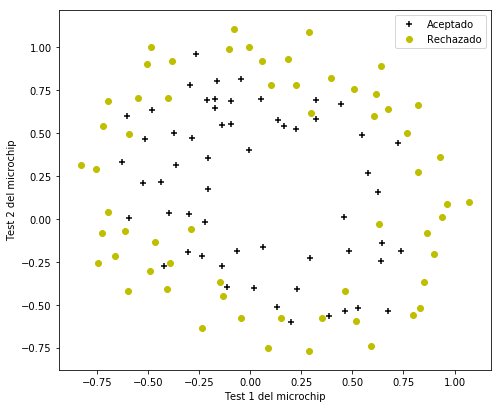

In [27]:
muestraGrafica(data2, 'Test 1 del microchip', 'Test 2 del microchip', 'Aceptado', 'Rechazado', axes=None)

Parece evidente que en este caso los ejemplos no son linealmente separables y vamos a tener que crear variables polinómicas.

#### Polinomios

Como podemos ver en la gráfica anterior los ejemplos no son linealmente separables. Por este motivo, en primer lugar, vamos a crear nuevas variables del modelo que nos permitan obtener fronteras de decisión no lineales. Para ello vamos a utilizar la función `PolynomialFeatures` que nos provee scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Sigue los siguientes pasos:
* Aplicar la función PolynomialFeatures pasando como parámetro de entrada el valor 6 ya que vamos a generar todos los términos polinómicos de $x_1$ y $x_2$ hasta la potencia 6: en total hay 28 combinaciones (por tanto se generan 28 variables).
* Una vez creado el objeto que nos permite realizar dicha transformación llamamos a la función `fit_transform` utilizando como parámetro la matriz $X$ que contiene los valores de las variables de entrada de nuestro problema.
* Esta función tiene dos partes (fit y transform)
    * La parte fit aprende los polinomios para generar las nuevas variables
    * La parte transform aplica los polinomios generados para transformar los datos de entrada y que como consecuencia pasemos de tener dos variables de entrada a 28.

**NOTA:** los términos polinómicos de las variables $a$ y $b$ hasta la potencia $p=3$ serían: $1, a, b, a^2, b^2, a^3, b^3, a \cdot b, a \cdot b^2, a^2\cdot b^2$
* Es decir, cada variable se eleva a todas las potencias entre 0 y p, y las combinaciones entre ellas no incluyen los términos elevados a p

In [56]:
from sklearn.preprocessing import PolynomialFeatures

# Almacena en XX el nuevo conjunto de datos transformado
poly = PolynomialFeatures(6)
XX = poly.fit_transform(X)
print(XX.shape)

(118, 28)


#### Función de coste regularizada
Al haber añadido tantas variables, corremos el serio riesgo de ajustarnos demasiado a los datos de entrenamiento (sobreaprender) y por tanto de no generalizar bien para nuevos ejemplos. Por ello, vamos a implementar la regresión logística con regularización en la que se penalizan aquellos parámetros con valores muy grandes, haciendo que el modelo no pueda ajustarse perfectamente a los datos de entrenamiento con el objetivo de obtener una mejor generalización.

Veamos cómo cambia la función de coste.
* Observar que se introduce el sumatorio de los parámetros $\theta$ al cuadrado ponderado por el valor del parámetro $\lambda$
    * Si $\lambda=0$ obtenemos la función de coste implementada en la primera parte de la práctica
    * Si $\lambda>0$ la función de coste trata de disminuir el valor de los parámetros $\theta$ del modelo
        * A mayor valor de $\lambda$ menores serán los valores de los parámetros $\theta$ que obtenedremos ya que trataremos de minimizarlos (al ser parte de la la función de coste)
    
#### $$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\big[y^{(i)}\, log\,( h_\theta\,(x^{(i)}))+(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
#### Función de coste vectorizada

#### $$ J(\theta) = -\frac{1}{m}\big((\,log\,(h_\theta(X))^Ty+(\,log\,(1-h_\theta(X))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

donde

$$ h_\theta(X) = g(X\cdot \theta) $$

Ahora, implementa la función de coste que inluye la regularización. Para ello se debe seguir usando la función sigmoide definida en la primera parte de la práctica.

**CUIDADO: Recuerda que el $\theta_0$ no se regulariza.**

In [29]:
def funcionCosteRegularizada(theta, valorLambda, XX, y):
    m = y.size
    h = sigmoide(XX.dot(theta))    
    
    with np.errstate(divide='raise'):
        try:
            r = (valorLambda / (2 * m)) * np.sum(np.square(theta[1:]))
            J = (-1 / m) * (   (np.log(h).T.dot(y)) + (np.log(1 - h).T).dot(1 - y) ) + r
        except FloatingPointError: J = np.inf
    
    
    return J

Vamos a seguir los mismos pasos que antes para implementar la regresión logística regularizada. Para poder usar la función `minimize`, debemos crear una función que calcule las derivadas parciales de los parámetros. Recordamos las derivadas parciales de la regresión logística regularizada

#### Derivada parcial

#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})\cdot x^{(i)}_{j} + \frac{\lambda}{m}\theta_{j}$$ 
####  Derivada parcial vectorizada
#### $$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(h_\theta(X)-y) + \frac{\lambda}{m}\theta_{j}$$

**CUIDADO: Recuerda que el $\theta_0$ no se regulariza.**

Definir la función que realiza la derivada parcial de los parámetros de la regresión logística regularizada en base al error cometido. Para ello se debe aplicar la ecuación de la derivada parcial vectorizada.

**NOTA: Esta función la vamos a usar en una función minimize que realizará el descenso por gradiente. Dicha función en vez de pasar theta como una matriz de (3, 1), nos pasará una de (3, ) por lo que debes hacer un reshape antes de realizar el producto entre X y theta**

In [30]:
def derivadaParcialRegularizada(theta, valorLambda, XX, y):
    m = y.size
    theta = theta.reshape(-1, 1)

    h = sigmoide(XX.dot(theta))
    
    derParcial = (1 / m) * XX.T.dot(h - y) + np.vstack((0,valorLambda/m * theta[1:]))
        
    return(derParcial.flatten()) # La salida debe ser un vector

Ejercicio:
* Inicializa los valores iniciales de la regresión logística a una columna de ceros
* Llama a la función que calcula el coste del modelo con los datos transformados ($XX$) mediante los polinomios aprendidos previamente y el parámetro $\lambda=1.0$.
* Llama a la función que calcula la derivada parcial con los mismos parámetros y comprueba que funciona correctamente.

In [31]:
# Columna de ceros como valores inciales de los parametros del modelo (guardar en thetaInicial)
thetaInicial = np.zeros((XX.shape[1]))
# Llamada a la funcion que calcula el coste del modelo inicial (guardar en coste)
coste = funcionCosteRegularizada(thetaInicial, 1.0, XX, y)
# Llamada a la funcion que realiza la derivada parcial (guardar en derParcial)
derParcial = derivadaParcialRegularizada(thetaInicial, 1.0, XX, y)

print('Coste del modelo inicial: \n', coste)
print('Derivada parcial: \n', derParcial)

Coste del modelo inicial: 
 [0.69314718]
Derivada parcial: 
 [8.47457627e-03 1.87880932e-02 7.77711864e-05 5.03446395e-02
 1.15013308e-02 3.76648474e-02 1.83559872e-02 7.32393391e-03
 8.19244468e-03 2.34764889e-02 3.93486234e-02 2.23923907e-03
 1.28600503e-02 3.09593720e-03 3.93028171e-02 1.99707467e-02
 4.32983232e-03 3.38643902e-03 5.83822078e-03 4.47629067e-03
 3.10079849e-02 3.10312442e-02 1.09740238e-03 6.31570797e-03
 4.08503006e-04 7.26504316e-03 1.37646175e-03 3.87936363e-02]


In [32]:
Test.assertEquals(np.round(coste, 5), 0.69315,'Valor de coste incorrecto')
Test.assertEquals(list(np.round(derParcial[0:5], 5)), [0.00847, 0.01879, 8e-05, 0.05034, 0.0115], 'Valores de la derivada parcial incorrectos')

1 test passed.
1 test passed.


### Efecto de $\lambda$ en los resultados
Por último vamos a analizar el efecto del parámetro $\lambda$ en los resultados obtenidos. Para ello vamos a analizar 3 valores: 0, 1 y 100. Para cada valor hay que realizar el siguiente proceso:
* Llamar a la función `minimize` (descenso por gradiente) pasando como argumentos de entrada:
    * La función que calcula el coste del modelo
    * Los valores iniciales del modelo que acabamos de asignar (**en una fila**)
    * Una tupla que contiene: el valor de $\lambda$, los datos transformados con los polinomios (XX) y las clases de los 118 ejemplos (parámetro args)
    * La función que realiza la derivada parcial de los parámetros del modelo (parámetro jac)
    * El número máximo de iteraciones que lo fijamos a 3000
* Realizar la predicción de los ejemplos del histórico (datos guardados en XX) con el modelo aprendido (res2.x, que debes transformarlo a una columna) **(llamada a la función prediccion definida anteriormente)**
* Calcular el porcentaje de acierto del modelo (se calcula como se ha realizado en la primera parte de la práctica)
* Mostrar la gráfica con la frontera de decisión generada por el modelo aprendido (llamada a la función que muestra los datos y sobre la cual mostramos la frontera de decisión generada siguiendo el ejemplo de la primera parte de la prácitca)
    * Como título de la figura mostrar el valor de $\lambda$, el porcentaje de acierto
* Mostrar los valores de los parámetros del modelo (print)

Deberías ser capaz de obtener las siguientes figura:
![Ejemplo](img6.png "Ejemplo")


C:\Users\javie\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Los valores de theta para lambda = 0.0  son [   35.10189059    44.11913065    69.27186415  -344.27887491
  -198.23454286  -184.22833064  -295.8202461   -621.73266075
  -510.84932739  -328.31184667  1094.69984596  1269.5856495
  1757.74846474   900.93757436   436.58877019   471.12012754
  1236.23878305  1822.82058176  1929.66782631  1131.05327437
   463.79936762 -1142.11697343 -2020.95915494 -3463.39950565
 -3484.51063366 -3252.26725151 -1546.00918849  -510.41272817] 

Los valores de theta para lambda = 1.0  son [ 1.27268739  0.62557016  1.1809665  -2.01919822 -0.91761468 -1.43194199
  0.12375921 -0.36513086 -0.35703388 -0.17485805 -1.45843772 -0.05129676
 -0.61603963 -0.2746414  -1.19282569 -0.24270336 -0.20570022 -0.04499768
 -0.27782709 -0.29525851 -0.45613294 -1.04377851  0.02762813 -0.29265642
  0.01543393 -0.32759318 -0.14389199 -0.92460119] 

Los valores de theta para lambda = 100.0  son [ 0.02188603 -0.01748169  0.00571031 -0.0551694  -0.01314888 -0.03859919
 -0.01846356 -0.0077

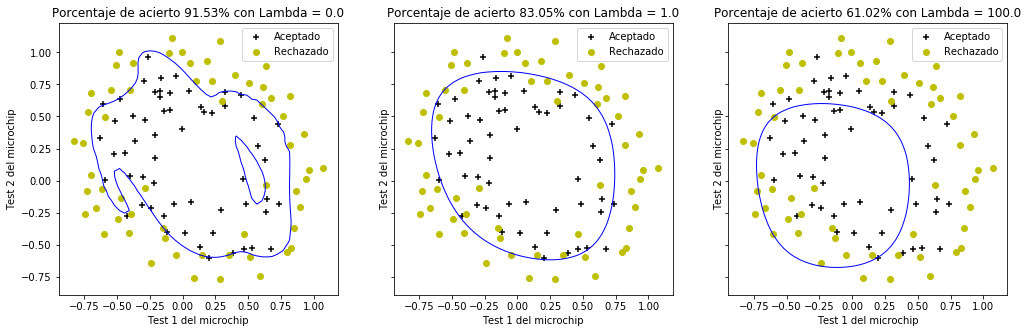

In [50]:
# Queremos una figura con 3 subplots
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# Fronteras de decisión
# Lambda = 0 : No se realiza regularización --> modelo muy flexible: sobre-entrenado
# Lambda = 1 : Parece que es un buen modelo: simple y preciso
# Lambda = 100 : Demasiada regularización: mucho bías

poly = PolynomialFeatures(6)
x1_min, x1_max = XX[:,1].min(), XX[:,1].max(),
x2_min, x2_max = XX[:,2].min(), XX[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
xx = poly.fit_transform(np.hstack((xx1.reshape(-1,1), xx2.reshape(-1, 1))))

# Crea la variable valoresLambda
valoresLambda = np.array([0.0, 1.0, 100.0])
for i, valorLambda in enumerate(valoresLambda):
    # Optimización de los parámetros del modelo en base a la función de coste, utilizar minimize
    res2 = minimize(funcionCosteRegularizada, thetaInicial, args=(valorLambda, XX, y), jac=derivadaParcialRegularizada, options={'maxiter':3000})
    # Ponemos los parámetros que están en res2.x en formato columna con reshape (guardar en thetas)
    thetas = res2.x.reshape(-1, 1)
    
    # Obtener las predicciones del modelo (thetas) para los datos transformados con los polinomios (XX)
    p = prediccion(thetas, XX)
    
    # Calcular el porcentaje de acierto como hemos realizado en la primera parte de la práctica
    boolean_array = (p == y)
    correct = np.sum(boolean_array)
    accuracy = correct / p.size * 100
    
    # Gráfica que muestra los ejemplos, utiliza como último parámetro axes.flatten()[i] (le pasamos el manejador de la figura correspondiente)
    muestraGrafica(data2, 'Test 1 del microchip', 'Test 2 del microchip', 'Aceptado', 'Rechazado', axes=axes.flatten()[i])
    axes[i].set_title('Porcentaje de acierto ' + str(np.round(accuracy, 2)) + "% con Lambda = " + str(valorLambda))
    
    # Mostramos la frontera de decisión
    h = sigmoide(xx.dot(thetas))
    h = h.reshape(xx1.shape)
    
    axes[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')
    
    # Mostrar los valores de theta para cada lambda "Los valores de theta para lambda = XX son [a, b, c...]"
    print("Los valores de theta para lambda =", valorLambda, " son", thetas.flatten(), "\n")

In [43]:
Test.assertEqualsNP(np.round(thetas.T, 4), np.round([[ 0.02188603, -0.01748169,  0.00571031, -0.0551694 , -0.01314888,
        -0.03859919, -0.01846356, -0.00773236, -0.00892434, -0.02280491,
        -0.04343876, -0.00235623, -0.01415631, -0.00349509, -0.04143634,
        -0.02100597, -0.00471924, -0.00359133, -0.00632236, -0.00502443,
        -0.03197706, -0.03416353, -0.00107628, -0.00702623, -0.00038506,
        -0.0079824 , -0.00154778, -0.04108711]], 4), 'Valor de thetas con lambda = 100 incorrecto' )

1 test passed.


### Conclusiones

Podéis observar los siguientes hechos:
* Con $\lambda=0$ el modelo obtenido es muy complejo puesto que está muy ajustado a los datos con los que ha sido aprendido. El porcentaje de acierto es muy alto (91.53%) y los valores de los parámetros $\theta$ son **muy altos**
* Con $\lambda=1$ el modelo obtenido es más sencillo y ofrece un buen balance entre complejidad y porcentaje de acierto (83.05%). Los valores de los parámetros $\theta$ son más bajos que antes.
* Con $\lambda=100$ el modelo obtenido es muy sencillo pero no se ajusta bien a los datos de entrenamiento y por tanto se obtiene un porcentaje de acierto muy bajo para este problema (61.02%). Los valores de los parámetros $\theta$ son muy bajos.

### Regresión logística regularizada con Scikit-learn
En este apartado vamos a tratar de replicar el resultado anterior con el paquete scikit-learn: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression

Para ello, vamos a volver a pintar las gráficas anteriores pero entrenaremos el modelo con la clase LogisticRegression de scikit-learn. 
 
`LogisticRegression` requiere de los siguientes parámetros:
* penalty: Elegir 'l2' (es el tipo de regularización a realizar)
* C: Es el valor que corresponde a lambda, pero en este caso $ C = 1/\lambda$. Tenlo en cuenta a la hora de establecer el valor de C. Cuando no queremos aplicar la regularización, este valor debe ser muy alto, por lo que el valor de lambda debe ser muy bajo, por ejemplo $lambda =0.1e-100$
* max_iter: Número máximo de iteraciones para el descenso por gradiente (400)
* solver: Este es el método a utilizar para buscar el mínimo. Puede ser cualquiera de entre {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’}. Utilizar newton-cg para esta prueba

Una vez creado el objeto de `LogisticRegression` debes utilizar el método `fit`. Como entrada toma la matriz $X$ (**CUIDADO** sin coger la columna de unos) y el vector $y$ (ponerlo en modo vector usando ravel).

Con dicha operación logramos ajustar los parámetros y ya podemos usar el objeto para predecir nuevos valores (los coeficientes obtenidos están en coef$\_$ y intercept$\_$, pero es más sencillo utilizar la función `predict_proba` para obtener las probabilidades de salida para cada ejemplo. Esta función recibe la matriz $X$ de entrada (sin la columna de unos) y devuelve una matriz de $m \times 2$. De esta matriz solo nos interesa la segunda columna que es la que tiene la probabilidad de que un ejemplo pertenezca a la clase 1. 

Utiliza los conocimientos adquiridos en la primera parte de la práctica y en el ejercicio anterior para obtener unas figuras lo más parecidas posibles a las anteriores.

**Nota:** Para calcular el porcentaje de acierto puedes usar el método `LogisticRegression.predict()` que devuelve la clase asignada a cada ejemplo.

(118, 2) (118, 28) (2500, 28)
Los valores de theta para lambda = 1e-101  son [   38.20523148    55.60095127    97.73255193  -369.38717015
  -177.16522902  -194.08129426  -366.43455132  -840.27253238
  -716.55162049  -508.6621443   1183.09666102  1279.24665654
  1905.80936534   912.72100449   512.52869752   574.32560921
  1628.79029726  2547.16255821  2904.77430556  1768.68040789
   778.90667621 -1258.77142851 -2260.37834617 -4139.27297509
 -4279.78293643 -4211.73761329 -2043.65083725  -745.04937088] 

(118, 2) (118, 28) (2500, 28)
Los valores de theta para lambda = 1.0  son [ 1.27273852  0.62527427  1.18107953 -2.01995701 -0.91743361 -1.43166228
  0.12400943 -0.36552879 -0.35723375 -0.1751281  -1.45816817 -0.05099315
 -0.61556795 -0.27470949 -1.19281161 -0.24218951 -0.20599958 -0.04473522
 -0.27778736 -0.29537501 -0.45635027 -1.04321271  0.02777197 -0.29243756
  0.0155633  -0.32738395 -0.14388956 -0.92464266] 

(118, 2) (118, 28) (2500, 28)
Los valores de theta para lambda = 100.0  son

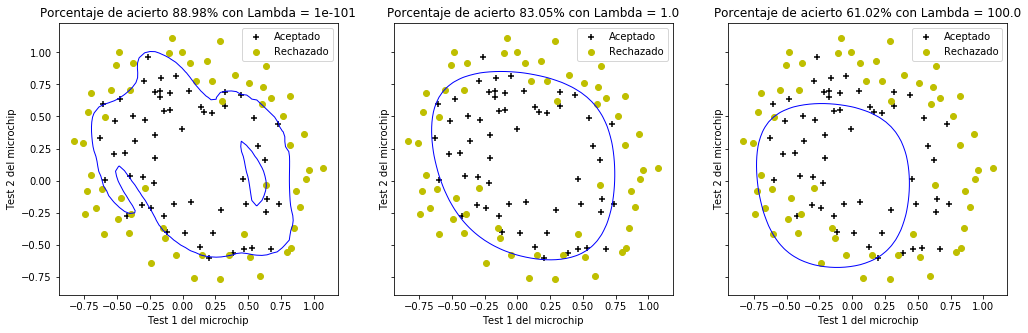

In [54]:
# Se importa de la libreria scikit-learn de python (sklearn) el paquete correspondiente a la regresión lineal
from sklearn.linear_model import LogisticRegression

fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# Fronteras de decisión
# Lambda = 0.1e-100 : No se realiza regularización --> modelo muy flexible: sobre-entrenado
# Lambda = 1 : Parece que es un buen modelo: simple y preciso
# Lambda = 100 : Demasiada regularización: mucho bías

# Crea la variable valoresLambda
valoresLambda = np.array([0.1e-100, 1, 100])

for i, valorLambda in enumerate(valoresLambda):
 
    # Se incializa el modelo llamando al constructor de la regresión lineal: todos los parámetros se asignan a los valores mencionados anteriormente
    LogReg = LogisticRegression(penalty='l2', C=1/valorLambda, max_iter=400, solver='newton-cg')
    # Utiliza fit para ajustar el modelo a los datos XX con clases y (recuerda no pasar la columna de 1's)
    LogReg.fit(XX[:, 1:], y.ravel())


    # Cálculo del porcentaje de acierto (recuerda no pasar la columna de 1's)
    p = LogReg.predict(XX[:, 1:]).reshape(-1, 1)
    #p = prediccion(np.hstack((LogReg.intercept_, LogReg.coef_[0, :])).reshape(-1, 1), XX)
    boolean_array = (p == y)
    correct = np.sum(boolean_array)
    accuracy = correct / p.size * 100

    # Gráfica que muestra los ejemplos, utiliza como último parámetro axes.flatten()[i] (le pasamos el manejador de la figura correspondiente)
    muestraGrafica(data2, 'Test 1 del microchip', 'Test 2 del microchip', 'Aceptado', 'Rechazado', axes=axes.flatten()[i])
    axes[i].set_title('Porcentaje de acierto ' + str(np.round(accuracy, 2)) + "% con Lambda = " + str(valorLambda))

    # Mostramos la frontera de decisión, recuerda utilizar axes.flatten()[i] para utilizar el plot correspondiente
    # Recuerda no pasar la columna de 1's al predecir
    h = LogReg.predict_proba(xx[:, 1:])[:, 1]
    h = h.reshape(xx1.shape)
    axes[i].contour(xx1, xx2, h, [0.5], linewidths=1, colors='b')

    # Mostrar los valores de theta para cada lambda "Los valores de theta para lambda = XX son [a, b, c...]"
    print("Los valores de theta para lambda =", valorLambda, " son", np.hstack((LogReg.intercept_, LogReg.coef_[0, :])), "\n") 

In [45]:
Test.assertEqualsNP(np.round(LogReg.coef_, 4), np.round([[-0.01748172,  0.00571079, -0.05516894, -0.01314876, -0.03859858,
        -0.01846356, -0.00773219, -0.00892429, -0.02280452, -0.04343846,
        -0.00235623, -0.01415612, -0.00349507, -0.04143588, -0.02100593,
        -0.00471917, -0.00359131, -0.00632226, -0.0050244 , -0.03197675,
        -0.03416335, -0.00107629, -0.00702615, -0.00038506, -0.0079823 ,
        -0.00154779, -0.04108677]], 4), 'Valor de LogReg.coef_ con lambda = 100 incorrecto' )
Test.assertEqualsNP(np.round(LogReg.intercept_, 4), np.round([ 0.02187771], 4), 'Valor de LogReg.intercept_ con lambda = 100 incorrecto' )

1 test passed.
1 test passed.
